In [1]:
%matplotlib inline
from scipy import *
import astropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.time import Time
from astropy.timeseries import LombScargle
from astropy import constants as ac
import exoplanet as xo
import celerite
import lightkurve as lk
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
from celerite2.theano import terms, GaussianProcess

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

## Importing in GJ1243 Light Curve and Flares

In [3]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans().remove_outliers()
    except:
            print(q)

In [4]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']

### Masking out Flares

In [5]:
f_mask = np.zeros_like(gj1243lc.time, dtype=bool)
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0.25
    c2 = 0.5  
    buffer = (gj1243lc.time >= t_starts[i] - c1*dur) & (gj1243lc.time <= t_stops[i] + c2*dur)
    temp = (gj1243lc.time >= t_starts[i]) & (gj1243lc.time <= t_stops[i])
    f_mask = f_mask + buffer
print(f_mask)
no_flares = np.where((f_mask == False))[0]

[False False False ... False False False]


Text(0.5, 0, 'Time - 2457000 [BTJD days]')

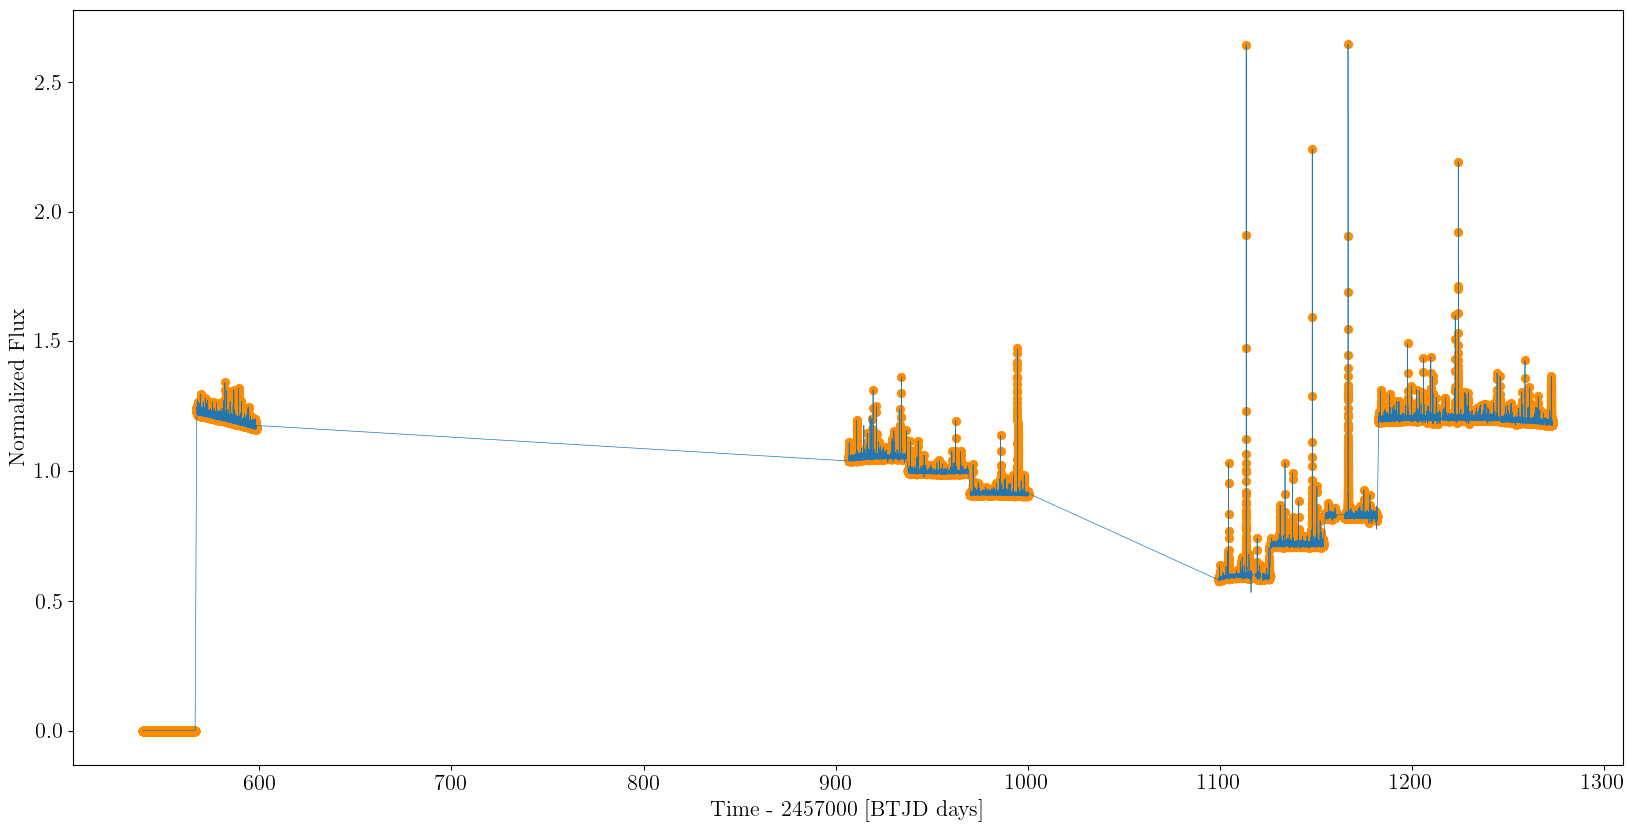

In [7]:
flares_x=gj1243lc.time[f_mask]
flares_y = gj1243lc.flux[f_mask]/np.nanmedian(gj1243lc.flux)

fig = plt.figure(figsize=(20,10))

fig.subplots_adjust(hspace=0.3, wspace=0.4)



plt.plot(gj1243lc.time[:84887],gj1243lc.flux[:84887]/np.nanmedian(gj1243lc.flux),linewidth=0.5,alpha=0.99,color='C0')
plt.plot(gj1243lc.time[84888:217976],gj1243lc.flux[84888:217976]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(gj1243lc.time[217976:],gj1243lc.flux[217976:]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)


plt.scatter(flares_x,flares_y,linewidth=0.7,color='darkorange',s=35)



#Text
#plt.text(520, 3, 'DR 25', fontsize=18, color ='k')


plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

### Accounting for Quarterly Discontinuities

In [8]:
total_median = np.nanmedian(gj1243lc.flux[no_flares])
raw_flux = 1+((gj1243lc.flux - total_median)/total_median)

In [9]:
# arrays of start and stop times of each month of data
start_time = np.array([])
stop_time = np.array ([])
med_nf = np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
          (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))[0]
        start = np.min(gj1243_collection[i].time)
        stop = np.max(gj1243_collection[i].time)
        med = np.nanmedian(gj1243lc.flux[no_flares][month])
        start_time = np.append(start_time,start)
        stop_time = np.append(stop_time,stop)
        med_nf = np.append(med_nf,med)
        
    except:
        print(i)

In [10]:
#Array of median fluxes across each month of data

medflux=np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
          (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))[0]

        med = 1+((gj1243lc.flux[no_flares][month] - med_nf[i]))/total_median
        medflux = np.append(medflux,med)
    except:
            print(i)


In [11]:
def FlagCuts(flags, bad_flags = (16, 128, 2048)):

    '''
    return the indexes that pass flag cuts

    Ethan says for Kepler cut out [16, 128, 2048], can add more later.
    '''

    # convert flag array to type int, just in case
    flags_int = np.array(flags, dtype='int')
    # empty array to hold places where bad flags exist
    bad = np.zeros_like(flags)

    # these are the specific flags to reject on
    # NOTE: == 2**[4, 7, 11]
    # bad_flgs = [16, 128, 2048]

    # step thru each of the bitwise flags, find where exist
    for k in bad_flags:
        bad = bad + np.bitwise_and(flags_int, k)/k

#     # find places in array where NO bad flags are set
#     if returngood is True:
#         good = np.where((bad < 1))[0]
#         return good
#     else:
    return bad

Checking out month1 of data (no flares)

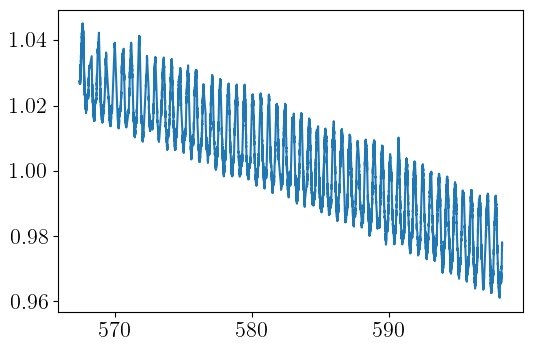

In [20]:
#month is the times of each month w/o flares
month1 = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[1].time)) & 
                 (gj1243lc.time[no_flares] <= np.max(gj1243_collection[1].time)) & 
                 (FlagCuts(gj1243lc.quality[no_flares]) < 1))[0]
y = medflux[month1]
x = gj1243lc.time[no_flares][month1]
yerr = 1+((gj1243lc.flux_err[no_flares][month1] - np.nanmedian(gj1243lc.flux[no_flares][month1]))/(np.nanmedian(gj1243lc.flux[no_flares][month1])))

plt.plot(x,y)

Setting up GP model that uses the Rotation Term within celerite2
https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

In [21]:
actual_period = 0.592 # previously measured by Jim using lomb-scargle 

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    jitter = pm.Lognormal("jitter", mu=np.log(np.mean(yerr)), sd=5.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    logperiod = pm.Lognormal("logperiod", mu=np.log(actual_period), sd=0.1)
    Q0 = pm.Lognormal("Q0", mu=0.0, sd=10.0)
    dQ = pm.Lognormal("dQ", mu=2.0, sd=10.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot, period=period, Q0=Q0, dQ=dQ, f=f
    )
    gp = GaussianProcess(
        kernel, t=x, diag=yerr ** 2 + jitter ** 2, mean=mean, quiet=True
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()


optimizing logp for variables: [f, dQ, Q0, logperiod, sigma_rot, rho, sigma, jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 111840.4229854007 -> 131523.1532378611


In [22]:
map_soln

{'mean': array(1.01600661),
 'jitter_log__': array(-7.70921033),
 'sigma_log__': array(-0.60423979),
 'rho_log__': array(2.47381121),
 'sigma_rot_log__': array(0.26639224),
 'logperiod_log__': array(-0.47285521),
 'Q0_log__': array(16.38566037),
 'dQ_log__': array(1.99869937),
 'f_interval__': array(-0.46929352),
 'jitter': array(0.00044868),
 'sigma': array(0.54648971),
 'rho': array(11.8675906),
 'sigma_rot': array(1.30524693),
 'logperiod': array(0.6232203),
 'Q0': array(13067782.00623822),
 'dQ': array(7.37945193),
 'f': array(0.44630512),
 'period': array(1.86492399),
 'pred': array([1.02733356, 1.02732017, 1.02730684, ..., 0.97773748, 0.9778377 ,
        0.97793754])}

(1.0, 1.05)

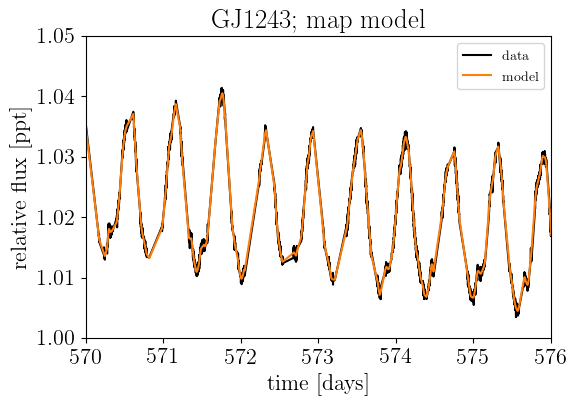

In [23]:
plt.plot(t, y, "k", label="data")
plt.plot(t, map_soln["pred"], color="C1", label="model")
plt.xlim(t.min(), t.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("GJ1243; map model")
plt.xlim(570,576)
plt.ylim(1.0,1.05)

Now to sample from the posterior (~30min run)

In [24]:
np.random.seed(10863087)
with model:
    trace = pmx.sample(
        tune=2500,
        draws=2000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, dQ, Q0, logperiod, sigma_rot, rho, sigma, jitter, mean]


Sampling 2 chains for 2_500 tune and 2_000 draw iterations (5_000 + 4_000 draws total) took 1667 seconds.


Convergence checks

In [25]:
with model:
    summary = pm.summary(
        trace,
        var_names=[
            "f",
            "dQ",
            "Q0",
            "period",
            "sigma_rot",
            "rho",
            "sigma",
            "jitter",
            "mean",
        ],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
f,4.620000e-01,2.690000e-01,0.100,9.230000e-01,4.000000e-03,3.000000e-03,5019.0,4552.0,4813.0,2523.0,1.0
dQ,2.639342e+13,1.324532e+15,0.000,7.658106e+07,2.094856e+13,1.481395e+13,3998.0,3998.0,4477.0,2559.0,1.0
Q0,1.019237e+15,3.990643e+16,86263.546,3.267445e+11,6.848214e+14,4.842835e+14,3396.0,3396.0,2534.0,1742.0,1.0
period,1.874000e+00,1.200000e-01,1.658,2.093000e+00,2.000000e-03,1.000000e-03,4388.0,4325.0,4472.0,2780.0,1.0
sigma_rot,1.400000e+00,4.020000e-01,0.756,2.168000e+00,7.000000e-03,5.000000e-03,3730.0,3130.0,4713.0,2849.0,1.0
rho,1.258800e+01,1.849000e+00,9.363,1.602300e+01,3.700000e-02,2.700000e-02,2484.0,2349.0,2701.0,2196.0,1.0
sigma,6.010000e-01,1.320000e-01,0.385,8.580000e-01,3.000000e-03,2.000000e-03,2504.0,2285.0,2822.0,2057.0,1.0
jitter,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,4845.0,4841.0,4833.0,3125.0,1.0
mean,1.016000e+00,3.250000e-01,0.412,1.634000e+00,6.000000e-03,4.000000e-03,3086.0,2834.0,3249.0,2507.0,1.0


Plotting Posterior distribution over the rotation period

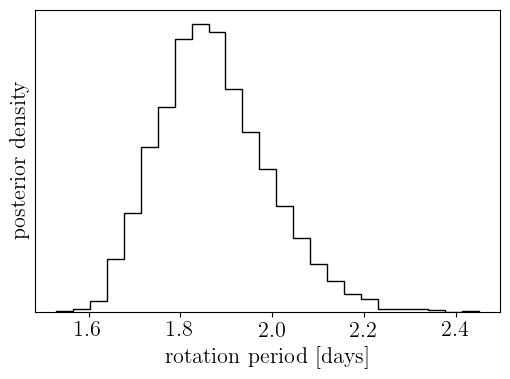

In [26]:
period_samples = trace["period"]
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")